# def

In [2]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_rows = 300
import math
import datetime as dt
from tableone import TableOne, load_dataset
import itertools
import random
import scipy.stats as stats

In [3]:
df_type = pd.read_csv("df_mixAK_fea4_C3.csv")
df_type_filt = df_type.loc[:,["stay_id","groupHPD"]]
df_type_filt = df_type_filt.drop_duplicates()
all_lst = df_type_filt.stay_id.unique().tolist()
print("纳入患者数量：",len(all_lst))

df_type_filt["groupHPD"].value_counts()

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


纳入患者数量： 4713


2    3055
1    1298
3     360
Name: groupHPD, dtype: int64

# 定义恢复模式
先判断一下每个时间的肾脏情况，再考虑时间来综合判断恢复模式

肾脏情况判定：
- 尿量不满足KDIGO AKI 定义时，判定为完全恢复C(complete recovery)
- 肌酐不满足KDIGO AKI 定义时，判定为完全恢复C(complete recovery)
- 否则都为尚未恢复P (partial)

- 肌酐在基线肌酐的30%内时，判定为完全恢复

恢复模式判定：
- 快速恢复QR，3天内恢复(quick recovery ) 
- 缓慢恢复SR，7天内恢复（slow recovery） 
- 恶化W（worse） 
- 恢复指连续5个点 "不满足AKI定义的数量" 大于 "满足AKI定义的数量"


# 肾脏情况判定

## 获取数据-aki stage,aki_stage_uo，aki_stage_cre

In [4]:
## 获取每个时间点 由尿量或肌酐定义的最大stages
df_stage = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic//disease_definition/AKI/kdigo_stages_based_time.csv")
df_stage = df_stage[df_stage['time']>=0]
df_stage = df_stage[df_stage["stay_id"].isin(all_lst)]
df_stage.head(3)

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,stay_id,time,aki_stage_uo,aki_stage_creat,aki_stage
66,30003598,0,2.0,0.0,2.0
67,30003598,1,3.0,0.0,3.0
68,30003598,2,3.0,1.0,3.0


In [4]:
## 获取变化过程
ss = "aki_stage_creat"  
print(ss)
tmp_df = pd.DataFrame(columns=["stay_id", "state_crea_start", "state_crea_max", "state_crea_end"])
for i,j in df_stage.groupby(["stay_id"]):
    sstart = j[j["time"]==0][ss].tolist()[0]
    smax = sorted(j[ss].tolist()[1:-1])[-1]
    send = j[ss].tolist()[-1] 
    tmp_df.loc[len(tmp_df)] = [i, sstart, smax, send]
df = pd.merge(df_stage, tmp_df, how="inner",on="stay_id")

ss = "aki_stage_uo"  
print(ss)
tmp_df = pd.DataFrame(columns=["stay_id", "state_uo_start", "state_uo_max", "state_uo_end"])
for i,j in df_stage.groupby(["stay_id"]):
    sstart = j[j["time"]==0][ss].tolist()[0]
    smax = sorted(j[ss].tolist()[1:-1])[-1]
    send = j[ss].tolist()[-1] 
    tmp_df.loc[len(tmp_df)] = [i, sstart, smax, send]
df = pd.merge(df, tmp_df, how="inner",on="stay_id")

ss = "aki_stage" 
print(ss)
tmp_df = pd.DataFrame(columns=["stay_id", "state_start", "state_max", "state_end"])
for i,j in df_stage.groupby(["stay_id"]):
    sstart = j[j["time"]==0][ss].tolist()[0]
    smax = sorted(j[ss].tolist()[1:-1])[-1]
    send = j[ss].tolist()[-1] 
    tmp_df.loc[len(tmp_df)] = [i, sstart, smax, send]
df = pd.merge(df, tmp_df, how="inner",on="stay_id")
df.head(2)

aki_stage_creat


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


aki_stage_uo
aki_stage


,stay_id,time,aki_stage_uo,aki_stage_creat,aki_stage,state_crea_start,state_crea_max,state_crea_end,state_uo_start,state_uo_max,state_uo_end,state_start,state_max,state_end
0,30003598,0,2.0,0.0,2.0,0.0,1.0,1.0,2.0,3.0,0.0,2.0,3.0,0.0
1,30003598,1,3.0,0.0,3.0,0.0,1.0,1.0,2.0,3.0,0.0,2.0,3.0,0.0


## 定义变化过程 by 变好/变坏/不变
- 第一个点：time = 1 时的state
- 第二个点：整个过程中stages最大的点
- 第三个点：倒数5个点更多的一个状态

In [5]:
df_cut = df[['stay_id','time','state_crea_start', 'state_crea_max', 'state_crea_end', 'state_uo_start',
             'state_uo_max', 'state_uo_end','state_start','state_max', 'state_end']].drop_duplicates()

#################
t0 = "state_crea_start"
tm = "state_crea_max"
t1 = "state_crea_end"
tc = "state_crea_change"
# B
df_cut.loc[ (df_cut[tm] >= df_cut[t0]) &  (df_cut[tm] >= df_cut[t1]) & (df_cut[t1]==0), tc] = "CB"
df_cut.loc[ (df_cut[tm] >= df_cut[t0]) &  (df_cut[tm] >= df_cut[t1]) & (df_cut[t1]!=0), tc] = "PB"
df_cut.loc[ (df_cut[tm] <= df_cut[t0]) &  (df_cut[t1] <= df_cut[tm]) & (df_cut[t1]!=0), tc] = "PB"
df_cut.loc[ (df_cut[tm] <= df_cut[t0]) &  (df_cut[t1] <= df_cut[tm]) & (df_cut[t1]==0), tc] = "CB"

# W
df_cut.loc[ (df_cut[tm] >= df_cut[t0]) &  (df_cut[t1] >= df_cut[tm]),tc] = "W"
# S
df_cut.loc[ (df_cut[tm] == df_cut[t0]) &  (df_cut[t1] == df_cut[tm]),tc] = "S"

#################
t0 = "state_uo_start"
tm = "state_uo_max"
t1 = "state_uo_end"
tc = "state_uo_change"
# B
df_cut.loc[ (df_cut[tm] >= df_cut[t0]) &  (df_cut[tm] >= df_cut[t1]) & (df_cut[t1]==0), tc] = "CB"
df_cut.loc[ (df_cut[tm] >= df_cut[t0]) &  (df_cut[tm] >= df_cut[t1]) & (df_cut[t1]!=0), tc] = "PB"
df_cut.loc[ (df_cut[tm] <= df_cut[t0]) &  (df_cut[t1] <= df_cut[tm]) & (df_cut[t1]!=0), tc] = "PB"
df_cut.loc[ (df_cut[tm] <= df_cut[t0]) &  (df_cut[t1] <= df_cut[tm]) & (df_cut[t1]==0), tc] = "CB"

# W
df_cut.loc[ (df_cut[tm] >= df_cut[t0]) &  (df_cut[t1] >= df_cut[tm]),tc] = "W"
# S
df_cut.loc[ (df_cut[tm] == df_cut[t0]) &  (df_cut[t1] == df_cut[tm]),tc] = "S"

#################
t0 = "state_start"
tm = "state_max"
t1 = "state_end"
tc = "state_change"
# B
df_cut.loc[ (df_cut[tm] >= df_cut[t0]) &  (df_cut[tm] >= df_cut[t1]) & (df_cut[t1]==0), tc] = "CB"
df_cut.loc[ (df_cut[tm] >= df_cut[t0]) &  (df_cut[tm] >= df_cut[t1]) & (df_cut[t1]!=0), tc] = "PB"
df_cut.loc[ (df_cut[tm] <= df_cut[t0]) &  (df_cut[t1] <= df_cut[tm]) & (df_cut[t1]!=0), tc] = "PB"
df_cut.loc[ (df_cut[tm] <= df_cut[t0]) &  (df_cut[t1] <= df_cut[tm]) & (df_cut[t1]==0), tc] = "CB"

# W
df_cut.loc[ (df_cut[tm] >= df_cut[t0]) &  (df_cut[t1] >= df_cut[tm]),tc] = "W"
# S
df_cut.loc[ (df_cut[tm] == df_cut[t0]) &  (df_cut[t1] == df_cut[tm]),tc] = "S"


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
ss

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'aki_stage'

In [7]:
df_cut1 = df_cut[['stay_id','state_crea_change','state_uo_change', 'state_change']].drop_duplicates()
df_cut1 = pd.merge(df_cut1,df_type_filt, how="inner",on="stay_id")
df_type_filt_count = pd.DataFrame(df_type_filt.groupHPD.value_counts()).reset_index()
df_type_filt_count.columns = ["groupHPD","count"]

fea = "state_change" 
print(fea)
##
tmp_df = pd.DataFrame(df_cut1[df_cut1["groupHPD"]==3][[fea]].value_counts()).reset_index()
tmp_df["groupHPD"]=3
df_out = tmp_df

tmp_df = pd.DataFrame(df_cut1[df_cut1["groupHPD"]==2][[fea]].value_counts()).reset_index()
tmp_df["groupHPD"]=2
df_out = pd.concat([df_out,tmp_df],axis=0)

tmp_df = pd.DataFrame(df_cut1[df_cut1["groupHPD"]==1][[fea]].value_counts()).reset_index()
tmp_df["groupHPD"]=1
df_out = pd.concat([df_out,tmp_df],axis=0)
df_out = df_out.sort_values(["groupHPD"])
df_out = pd.merge(df_out,df_type_filt_count, how="inner",on="groupHPD")
df_out["percent"] = round(df_out[0] /df_out["count"] *100,2)
df_out.columns = ['type', 0, 'groupHPD', 'count', 'percent']
df_out.head(2)

state_change


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,type,0,groupHPD,count,percent
0,CB,838,1,1298,64.56
1,W,232,1,1298,17.87


In [8]:
df_out["dataset"] = "MIMIC"
df_out.columns = ['type', 'count', 'groupHPD', 'count_all', 'percent', 'dataset']
df_out.to_csv("./result/MIMIC_renal_recovery_1.csv",index=False)
df_out.head()

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,type,count,groupHPD,count_all,percent,dataset
0,CB,838,1,1298,64.56,MIMIC
1,W,232,1,1298,17.87,MIMIC
2,PB,174,1,1298,13.41,MIMIC
3,S,54,1,1298,4.16,MIMIC
4,CB,2201,2,3055,72.05,MIMIC


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


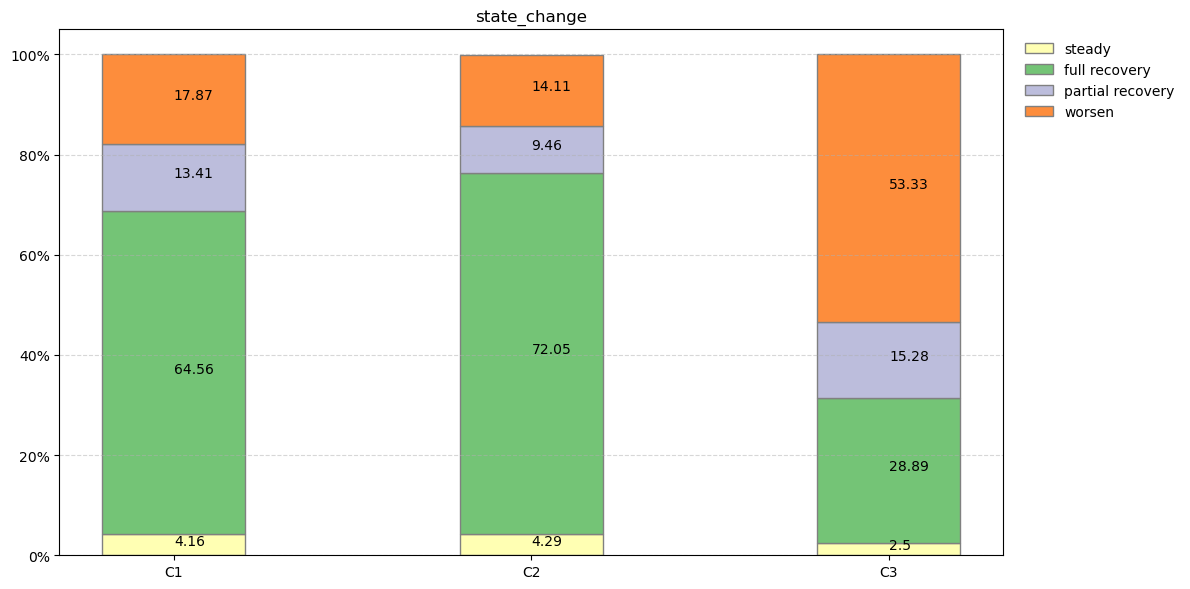

In [9]:
#plot
def text(y1,y2,y3,y4, sizes):
    plt.text(0,y1[0]/2 ,y1[0],size=sizes)
    plt.text(1,y1[1]/2,y1[1],size=sizes)
    plt.text(2,y1[2]/2,y1[2],size=sizes)
    
    plt.text(0,y1[0]+ y2[0]/2 ,y2[0],size=sizes)
    plt.text(1,y1[1]+ y2[1]/2 ,y2[1],size=sizes)
    plt.text(2,y1[2]+ y2[2]/2 ,y2[2],size=sizes)
    
    plt.text(0,y1[0]+ y2[0] +y3[0]/2 ,y3[0],size=sizes)
    plt.text(1,y1[1]+ y2[1] +y3[1]/2 ,y3[1],size=sizes)
    plt.text(2,y1[2]+ y2[2] +y3[2]/2 ,y3[2],size=sizes)
    
    plt.text(0,y1[0]+ y2[0] +y3[0] + y4[0]/2,y4[0],size=sizes)
    plt.text(1,y1[1]+ y2[1] +y3[1] + y4[1]/2,y4[1],size=sizes)
    plt.text(2,y1[2]+ y2[2] +y3[2] + y4[2]/2,y4[2],size=sizes)
    
#三组诊断时的AKI等级分布
y1 = df_out[df_out["type"]=="S"]["percent"].tolist()
y2 = df_out[df_out["type"]=="CB"]["percent"].tolist()
y3 = df_out[df_out["type"]=="PB"]["percent"].tolist()
y4 = df_out[df_out["type"]=="W"]["percent"].tolist()

x = ["C1","C2","C3"]
y1 = np.array(y1)
y2 = np.array(y2)
y3 = np.array(y3)
y4 = np.array(y4)

plt.figure(figsize=(12, 6))
plt.bar(x,y1,width=0.4,label='steady',color='#ffffb3',edgecolor='grey')
plt.bar(x,y2,width=0.4,bottom=y1,label='full recovery',color='#74c476',edgecolor='grey')
plt.bar(x,y3,width=0.4,bottom=y1+y2,label='partial recovery',color='#bcbddc',edgecolor='grey')
plt.bar(x,y4,width=0.4,bottom=y1+y2+y3,label='worsen',color='#fd8d3c',edgecolor='grey')

text(y1,y2,y3,y4,10)
plt.yticks(np.arange(0,110,20),[f'{i}%' for i in range(0,120,20)])
plt.grid(axis='y',alpha=0.5,ls='--')

plt.legend(frameon=False,bbox_to_anchor=(1.01,1))
plt.title(fea)
plt.tight_layout()
plt.show()

# 恢复模式判定(多少天恢复)
- 3天内恢复/7天内恢复/7天内不恢复

In [10]:
df_ = df_cut[["stay_id","time","state_change","state_uo_change","state_crea_change"]]
df_.head(1)

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,stay_id,time,state_change,state_uo_change,state_crea_change
0,30003598,0,CB,CB,W


In [11]:
## 定义恢复模式
# 快速恢复QR，48小时内恢复(quick recovery ) - 缓慢恢复SR，7天内恢复（slow recovery） - 恶化（worse） - 不清晰（unknow）
def state_definition(d,t,fea):
    # 快速恢复
    if list(set(d[fea].tolist()))[0] =="W":
        s = "W"
    elif max(d["time"]) > t and list(set(d[fea].tolist()))[0] =="CB":
        s = "Slow_CB"
    elif max(d["time"]) > t and list(set(d[fea].tolist()))[0] =="PB":
        s = "Slow_PB"
    elif max(d["time"]) <= t and list(set(d[fea].tolist()))[0] =="CB":
        s = "fast_CB"
    elif max(d["time"]) <= t and list(set(d[fea].tolist()))[0] =="PB":
        s = "fast_PB"
    elif list(set(d[fea].tolist()))[0] =="S":
        s = "S"
    else:
        s = "unknow"
    return s

## 得到每个stay_id的恢复模式
df_stayid_s = pd.DataFrame(columns=["stay_id","stayid_state"])
id_lst = df_.stay_id.unique()
fea = "state_change"
for id_ in id_lst:
    d = df_[df_["stay_id"]==id_]
    stayid_s = state_definition(d,12,fea)
    df_stayid_s.loc[len(df_stayid_s)] = [id_, stayid_s]

df_count_all = pd.DataFrame(df_type_filt["groupHPD"].value_counts()).reset_index()
df_count_all.columns = ["groupHPD", "count_all"]

tmp_df = pd.merge(df_stayid_s,df_type_filt, how="inner",on="stay_id")
tmp_df = tmp_df.groupby(["groupHPD","stayid_state"]).agg({"stay_id":"count"}).reset_index()
tmp_df = pd.merge(tmp_df,df_count_all, how="inner",on="groupHPD")
tmp_df["percent(%)"] = round(tmp_df["stay_id"]/tmp_df["count_all"]*100,2)
#tmp_df.sort_values(["groupHPD",'stayid_state'])

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
tmp_df["dataset"] = "MIMIC"
tmp_df.to_csv("./result/MIMIC_renal_recovery_2.csv",index=False)
tmp_df.head()

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,groupHPD,stayid_state,stay_id,count_all,percent(%),dataset
0,1,S,54,1298,4.16,MIMIC
1,1,Slow_CB,551,1298,42.45,MIMIC
2,1,Slow_PB,126,1298,9.71,MIMIC
3,1,W,232,1298,17.87,MIMIC
4,1,fast_CB,287,1298,22.11,MIMIC


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


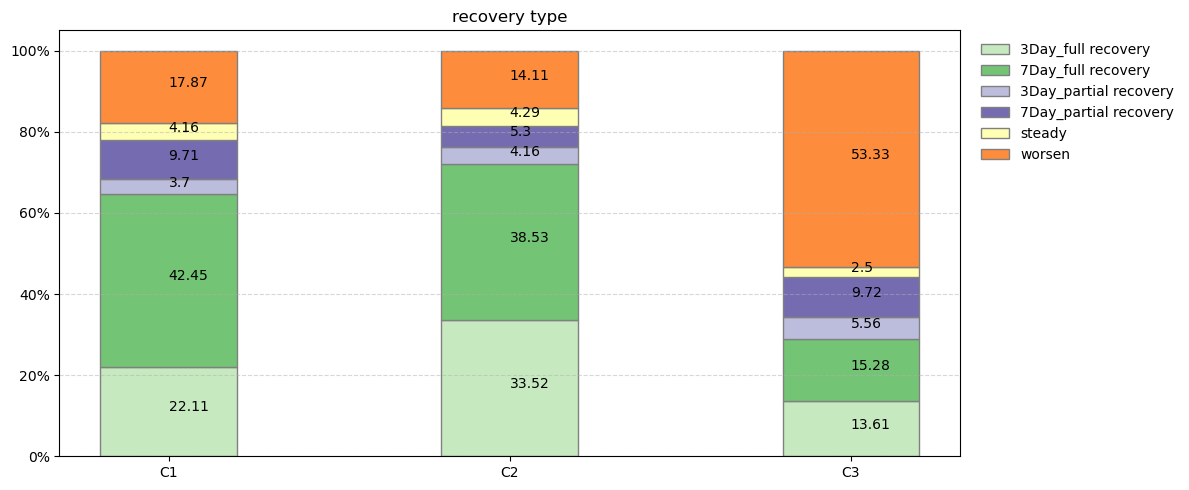

In [13]:
def text(y1,y2,y3,y4,y5,y6,sizes):
    plt.text(0,y1[0]/2 ,y1[0],size=sizes)
    plt.text(1,y1[1]/2,y1[1],size=sizes)
    plt.text(2,y1[2]/2,y1[2],size=sizes)
    
    plt.text(0,y1[0]+ y2[0]/2 ,y2[0],size=sizes)
    plt.text(1,y1[1]+ y2[1]/2 ,y2[1],size=sizes)
    plt.text(2,y1[2]+ y2[2]/2 ,y2[2],size=sizes)
    
    plt.text(0,y1[0]+ y2[0] +y3[0]/2 ,y3[0],size=sizes)
    plt.text(1,y1[1]+ y2[1] +y3[1]/2 ,y3[1],size=sizes)
    plt.text(2,y1[2]+ y2[2] +y3[2]/2 ,y3[2],size=sizes)
    
    plt.text(0,y1[0]+ y2[0] +y3[0] + y4[0]/2,y4[0],size=sizes)
    plt.text(1,y1[1]+ y2[1] +y3[1] + y4[1]/2,y4[1],size=sizes)
    plt.text(2,y1[2]+ y2[2] +y3[2] + y4[2]/2,y4[2],size=sizes)
    
    plt.text(0,y1[0]+ y2[0] +y3[0] + y4[0]+y5[0]/2,y5[0],size=sizes)
    plt.text(1,y1[1]+ y2[1] +y3[1] + y4[1]+y5[1]/2,y5[1],size=sizes)
    plt.text(2,y1[2]+ y2[2] +y3[2] + y4[2]+y5[2]/2,y5[2],size=sizes)
    
    plt.text(0,y1[0]+ y2[0] +y3[0] + y4[0]+y5[0]+y6[0]/2,y6[0],size=sizes)
    plt.text(1,y1[1]+ y2[1] +y3[1] + y4[1]+y5[1]+y6[1]/2,y6[1],size=sizes)
    plt.text(2,y1[2]+ y2[2] +y3[2] + y4[2]+y5[2]+y6[2]/2,y6[2],size=sizes)    

    
#三组诊断时的AKI等级分布
y1 = tmp_df[tmp_df["stayid_state"]=="fast_CB"].loc[:,["groupHPD","percent(%)"]].sort_values("groupHPD")["percent(%)"].tolist()
y2 = tmp_df[tmp_df["stayid_state"]=="Slow_CB"].loc[:,["groupHPD","percent(%)"]].sort_values("groupHPD")["percent(%)"].tolist()
y3 = tmp_df[tmp_df["stayid_state"]=="fast_PB"].loc[:,["groupHPD","percent(%)"]].sort_values("groupHPD")["percent(%)"].tolist()
y4 = tmp_df[tmp_df["stayid_state"]=="Slow_PB"].loc[:,["groupHPD","percent(%)"]].sort_values("groupHPD")["percent(%)"].tolist()
y5 = tmp_df[tmp_df["stayid_state"]=="S"].loc[:,["groupHPD","percent(%)"]].sort_values("groupHPD")["percent(%)"].tolist()
y6 = tmp_df[tmp_df["stayid_state"]=="W"].loc[:,["groupHPD","percent(%)"]].sort_values("groupHPD")["percent(%)"].tolist()

x = ["C1","C2","C3"]
y1 = np.array(y1)
y2 = np.array(y2)
y3 = np.array(y3)

plt.figure(figsize=(12, 5)) 
plt.bar(x,y1,width=0.4,label='3Day_full recovery',color='#c7e9c0',edgecolor='grey')
plt.bar(x,y2,width=0.4,bottom=y1,label='7Day_full recovery',color='#74c476',edgecolor='grey')
plt.bar(x,y3,width=0.4,bottom=y1+y2,label='3Day_partial recovery',color='#bcbddc',edgecolor='grey')
plt.bar(x,y4,width=0.4,bottom=y1+y2+y3,label='7Day_partial recovery',color='#756bb1',edgecolor='grey')
plt.bar(x,y5,width=0.4,bottom=y1+y2+y3+y4,label='steady',color='#ffffb3',edgecolor='grey')
plt.bar(x,y6,width=0.4,bottom=y1+y2+y3+y4+y5,label='worsen',color='#fd8d3c',edgecolor='grey')
text(y1,y2,y3,y4,y5,y6,10)

plt.yticks(np.arange(0,120,20),[f'{i}%' for i in range(0,120,20)])
plt.grid(axis='y',alpha=0.5,ls='--')

plt.legend(frameon=False,bbox_to_anchor=(1.01,1))
plt.title("recovery type")
plt.tight_layout()
plt.show()

# 每个患者恢复到AKI 0的时间长度

In [14]:
# df_stage = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic//disease_definition/AKI/kdigo_stages_based_time.csv")

# df_len = df_stage
# df_len = df_len[df_len["aki_stage"]>0]
# df_len = df_len.sort_values(["stay_id","time"],ascending=False)
# df_len = df_len.groupby(["stay_id"]).head(1)
# df_len = pd.merge(df_len,df_type_filt,how="inner",on="stay_id")
# df_len["time"] = df_len["time"]*6 /24
# df_len = df_len.rename(columns={"time":"during_time"})

# df_ = df_cut[["stay_id","state_change","state_uo_change","state_crea_change"]].drop_duplicates()
# df_len = pd.merge(df_len, df_, how="left",on=['stay_id'])

# import seaborn as sns
# sns.boxplot(x="state_change",y="during_time",data=df_len,hue="groupHPD",palette="Set3") 
# plt.legend(loc='upper right')
# plt.ylabel("during_time (day)")
# plt.show()

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
sss

# 基于不同定义的恢复v2

In [ ]:
df_cut.state_crea_change.unique()

In [ ]:
df_ = df_cut[["stay_id","state_change","state_uo_change","state_crea_change"]].drop_duplicates()

df_.loc[(df_["state_uo_change"].isin(["CB","PB"])) &(df_["state_crea_change"].isin(["CB","PB"])),"type"] = "UC_CC"
df_.loc[(df_["state_uo_change"].isin(["W","S"])) &(df_["state_crea_change"].isin(["W","S"])) ,"type"] = "UC_PP"
df_.loc[(df_["state_uo_change"].isin(["CB","PB"])) &(df_["state_crea_change"].isin(["W","S"])) ,"type"] = "UC_CP"
df_.loc[(df_["state_uo_change"].isin(["W","S"])) &(df_["state_crea_change"].isin(["CB","PB"])),"type"] = "UC_PC"

In [ ]:
df_sur = pd.read_csv("sk_survival.csv")
df_sur = df_sur[['stay_id', 'groupHPD','mortality_28d', 'survival_28day']]

df_creauo = df_
df_admit = pd.merge(df_sur,df_creauo,how="inner",on="stay_id")
map_dict = {"UC_CC":1,"UC_PC":2,"UC_CP":3,'UC_PP':4}
df_admit["type_num"] = df_admit["type"].map(map_dict)
df_admit.to_csv("sk_survival_肌酐尿量分别是否恢复_v2.csv", index=False)

df_type_filt_count = pd.DataFrame(df_type_filt.groupHPD.value_counts()).reset_index()
df_type_filt_count.columns = ["groupHPD","count"]

df = df_admit.groupby(['groupHPD',"type_num"]).agg({"stay_id":"count"}).reset_index()
df = pd.merge(df, df_type_filt_count, how="left",on="groupHPD")
df["percent"] = round(df["stay_id"] /df["count"]*100 ,2) 
df["label"] = df["groupHPD"].astype("str") + "_" + df["type_num"].astype("int").astype("str")
df

In [ ]:
#plot
def text(y1,y2,y3,y4, sizes):
    plt.text(0,y1[0]/2 ,y1[0],size=sizes)
    plt.text(1,y1[1]/2,y1[1],size=sizes)
    plt.text(2,y1[2]/2,y1[2],size=sizes)
    
    plt.text(0,y1[0]+ y2[0]/2 ,y2[0],size=sizes)
    plt.text(1,y1[1]+ y2[1]/2 ,y2[1],size=sizes)
    plt.text(2,y1[2]+ y2[2]/2 ,y2[2],size=sizes)
    
    plt.text(0,y1[0]+ y2[0] +y3[0]/2 ,y3[0],size=sizes)
    plt.text(1,y1[1]+ y2[1] +y3[1]/2 ,y3[1],size=sizes)
    plt.text(2,y1[2]+ y2[2] +y3[2]/2 ,y3[2],size=sizes)
    
    plt.text(0,y1[0]+ y2[0] +y3[0] + y4[0]/2,y4[0],size=sizes)
    plt.text(1,y1[1]+ y2[1] +y3[1] + y4[1]/2,y4[1],size=sizes)
    plt.text(2,y1[2]+ y2[2] +y3[2] + y4[2]/2,y4[2],size=sizes)
    
#三组诊断时的AKI等级分布
y1 = df[df["type_num"]==1]["percent"].tolist()
y2 = df[df["type_num"]==2]["percent"].tolist()
y3 = df[df["type_num"]==3]["percent"].tolist()
y4 = df[df["type_num"]==4]["percent"].tolist()

x = ["C1","C2","C3"]
y1 = np.array(y1)
y2 = np.array(y2)
y3 = np.array(y3)
y4 = np.array(y4)

plt.figure(figsize=(9, 5))
plt.bar(x,y1,width=0.4,label='crea recovery + uo recovery',color='#ffffb3',edgecolor='grey')
plt.bar(x,y2,width=0.4,bottom=y1,label='crea recovery + uo no recovery',color='#74c476',edgecolor='grey')
plt.bar(x,y3,width=0.4,bottom=y1+y2,label='uo recovery + crea no recovery',color='#bcbddc',edgecolor='grey')
plt.bar(x,y4,width=0.4,bottom=y1+y2+y3,label='crea no recovery + uo no recovery',color='#fd8d3c',edgecolor='grey')


text(y1,y2,y3,y4,8)
plt.yticks(np.arange(0,120,20),[f'{i}%' for i in range(0,120,20)])
plt.grid(axis='y',alpha=0.5,ls='--')

plt.legend(frameon=False,bbox_to_anchor=(1.01,1))
plt.tight_layout()
plt.show()

# 基于不同定义的恢复v1

In [ ]:
df_stage = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic//disease_definition/AKI/kdigo_stages_based_time.csv")
df = df_stage

df.loc[df["aki_stage_uo"]==0,"state_uo"] = "C"
df.loc[df["aki_stage_uo"].isin([1,2,3]),"state_uo"] = "P"
df.loc[df["aki_stage_creat"].isin([1,2,3]),"state_crea"] = "P"
df.loc[df["aki_stage_creat"]==0,"state_crea"] = "C"
df.loc[df["aki_stage"].isin([1,2,3]),"state"] = "P"
df.loc[df["aki_stage"]==0,"state"] = "C"

df_ = df.loc[:,["stay_id","time","state_uo","state_crea","state"]]

In [ ]:
df = df_.sort_values(["stay_id","time"],ascending=False)
df = df.groupby(["stay_id"]).head(5)

tmp_df = pd.DataFrame(columns=["stay_id","uo_state_by_id","crea_state_by_id","state_by_id" ])
for i,j in df.groupby(["stay_id"]):
    uo_state_by_id = j["state_uo"].value_counts().head(1).index[0]
    crea_state_by_id = j["state_crea"].value_counts().head(1).index[0]
    state_by_id = j["state"].value_counts().head(1).index[0]
    tmp_df.loc[len(tmp_df)] = [i, uo_state_by_id, crea_state_by_id, state_by_id]
    
tmp_df.loc[(tmp_df["uo_state_by_id"]=="C")&(tmp_df["crea_state_by_id"]=="C"),"type"] = "UC_CC"
tmp_df.loc[(tmp_df["uo_state_by_id"]=="P")&(tmp_df["crea_state_by_id"]=="P"),"type"] = "UC_PP"
tmp_df.loc[(tmp_df["uo_state_by_id"]=="C")&(tmp_df["crea_state_by_id"]=="P"),"type"] = "UC_CP"
tmp_df.loc[(tmp_df["uo_state_by_id"]=="P")&(tmp_df["crea_state_by_id"]=="C"),"type"] = "UC_PC"
tmp_df = tmp_df[['stay_id', 'type']]
tmp_df.to_csv("肌酐尿量分别是否恢复.csv",index=False)

肌酐尿量都恢复 - UC_CC

肌酐恢复尿量未恢复 - UC_PC

尿量恢复肌酐未恢复 - UC_CP

尿量肌酐都未恢复 - UC_PP

In [ ]:
df_sur = pd.read_csv("sk_survival.csv")
df_sur = df_sur[['stay_id', 'groupHPD','mortality_28d', 'survival_28day']]

df_creauo = pd.read_csv("肌酐尿量分别是否恢复.csv")
df_admit = pd.merge(df_sur,df_creauo,how="inner",on="stay_id")
map_dict = {"UC_CC":1,"UC_PC":2,"UC_CP":3,'UC_PP':4}
df_admit["type_num"] = df_admit["type"].map(map_dict)
df_admit.to_csv("sk_survival_肌酐尿量分别是否恢复.csv", index=False)

df_type_filt_count = pd.DataFrame(df_type_filt.groupHPD.value_counts()).reset_index()
df_type_filt_count.columns = ["groupHPD","count"]

df = df_admit.groupby(['groupHPD',"type_num"]).agg({"stay_id":"count"}).reset_index()
df = pd.merge(df, df_type_filt_count, how="left",on="groupHPD")
df["percent"] = round(df["stay_id"] /df["count"]*100 ,2) 
df["label"] = df["groupHPD"].astype("str") + "_" + df["type_num"].astype("str")
df

In [ ]:
#plot
def text(y1,y2,y3,y4, sizes):
    plt.text(0,y1[0]/2 ,y1[0],size=sizes)
    plt.text(1,y1[1]/2,y1[1],size=sizes)
    plt.text(2,y1[2]/2,y1[2],size=sizes)
    
    plt.text(0,y1[0]+ y2[0]/2 ,y2[0],size=sizes)
    plt.text(1,y1[1]+ y2[1]/2 ,y2[1],size=sizes)
    plt.text(2,y1[2]+ y2[2]/2 ,y2[2],size=sizes)
    
    plt.text(0,y1[0]+ y2[0] +y3[0]/2 ,y3[0],size=sizes)
    plt.text(1,y1[1]+ y2[1] +y3[1]/2 ,y3[1],size=sizes)
    plt.text(2,y1[2]+ y2[2] +y3[2]/2 ,y3[2],size=sizes)
    
    plt.text(0,y1[0]+ y2[0] +y3[0] + y4[0]/2,y4[0],size=sizes)
    plt.text(1,y1[1]+ y2[1] +y3[1] + y4[1]/2,y4[1],size=sizes)
    plt.text(2,y1[2]+ y2[2] +y3[2] + y4[2]/2,y4[2],size=sizes)
    
#三组诊断时的AKI等级分布
y1 = df[df["type_num"]==1]["percent"].tolist()
y2 = df[df["type_num"]==2]["percent"].tolist()
y3 = df[df["type_num"]==3]["percent"].tolist()
y4 = df[df["type_num"]==4]["percent"].tolist()

x = ["C1","C2","C3"]
y1 = np.array(y1)
y2 = np.array(y2)
y3 = np.array(y3)
y4 = np.array(y4)

plt.figure(figsize=(9, 5))
plt.bar(x,y1,width=0.4,label='crea recovery + uo recovery',color='#ffffb3',edgecolor='grey')
plt.bar(x,y2,width=0.4,bottom=y1,label='crea recovery + uo no recovery',color='#74c476',edgecolor='grey')
plt.bar(x,y3,width=0.4,bottom=y1+y2,label='uo recovery + crea no recovery',color='#bcbddc',edgecolor='grey')
plt.bar(x,y4,width=0.4,bottom=y1+y2+y3,label='crea no recovery + uo no recovery',color='#fd8d3c',edgecolor='grey')


text(y1,y2,y3,y4,8)
plt.yticks(np.arange(0,120,20),[f'{i}%' for i in range(0,120,20)])
plt.grid(axis='y',alpha=0.5,ls='--')

plt.legend(frameon=False,bbox_to_anchor=(1.01,1))
plt.tight_layout()
plt.show()

In [ ]:
df_count_all = pd.DataFrame(df_type_filt["groupHPD"].value_counts()).reset_index()
df_count_all.columns = ["groupHPD", "count_all"]

df_state = df_.loc[:,["stay_id", "time", "state","state_uo","state_crea"]]
df_state =  pd.merge(df_state,df_type_filt, how="inner",on="stay_id")
df_state = df_state[df_state['time'].isin([-2,-1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])]

df_state_count = df_state.groupby(["time","groupHPD"]).agg({"stay_id":"count"}).reset_index()
df_state_count.columns = ["time","groupHPD","count"]

df_state_count.head(2)

In [ ]:
from matplotlib import pyplot as plt 
def feature_line_chart_plot(df, df_state_count,fea,label_lst,t1_lst,t2_lst,t3_lst):
    df1 = df[df["stay_id"].isin(t1_lst)]
    df2 = df[df["stay_id"].isin(t2_lst)]
    df3 = df[df["stay_id"].isin(t3_lst)]

    df1 = df1.groupby(["time","groupHPD",fea]).agg({"stay_id":"count"}).reset_index()
    df1 = df1[df1[fea]=="C"]
    df1 = pd.merge(df1,df_state_count, how="left",on=["time","groupHPD"])
    df1["percent"] = round(df1["stay_id"]/df1["count"]*100, 4)
    
    df2 = df2.groupby(["time","groupHPD",fea]).agg({"stay_id":"count"}).reset_index()
    df2 = df2[df2[fea]=="C"]
    df2 = pd.merge(df2,df_state_count, how="left",on=["time","groupHPD"])
    df2["percent"] = round(df2["stay_id"]/df2["count"]*100, 4)
    
    df3 = df3.groupby(["time","groupHPD",fea]).agg({"stay_id":"count"}).reset_index()
    df3 = df3[df3[fea]=="C"]
    df3 = pd.merge(df3,df_state_count, how="left",on=["time","groupHPD"])
    df3["percent"] = round(df3["stay_id"]/df3["count"]*100, 4)
    
    x1 = df1["time"].tolist()
    y1 =  df1["percent"].tolist()
    x2 = df2["time"].tolist()
    y2 =  df2["percent"].tolist()
    x3 = df3["time"].tolist()
    y3 =  df3["percent"].tolist()

    plt.figure(figsize=(3, 2)) 
    plt.plot(x1,y1,'s-',color = '#1b9e77',label=label_lst[0],linewidth=2,markersize=3)
    plt.plot(x2,y2,'o-',color = '#d95f02',label=label_lst[1],linewidth=2,markersize=3)
    plt.plot(x3,y3,'o-',color = '#7570b3',label=label_lst[2],linewidth=2,markersize=3)
    
    plt.xlabel("time after S-AKI (6 hour-window)")
    plt.ylabel("Recovery ratio(%)")
    plt.title(fea)
    plt.legend(label_lst)
    plt.show()

t1_lst = df_type_filt[df_type_filt["groupHPD"]==1].stay_id.unique()
t2_lst = df_type_filt[df_type_filt["groupHPD"]==2].stay_id.unique()
t3_lst = df_type_filt[df_type_filt["groupHPD"]==3].stay_id.unique()
label_lst = ["C1", "C2", "C3"]
fea_lst = ["state_crea","state_uo","state"]

for fea in fea_lst:
    feature_line_chart_plot(df_state, df_state_count, fea, label_lst,t1_lst,t2_lst,t3_lst)